In [1]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

In [2]:
fast_design = Overlay("fast.bit")

In [3]:
for i in fast_design.ip_dict:
    print(i)

fast_accel_0
axi_dma_0
processing_system7_0


In [4]:
dma = fast_design.axi_dma_0
fast = fast_design.fast_accel_0

In [5]:
image_path = "/home/xilinx/jupyter_notebooks/images/Emir_Abdelkader_4K.jpg" #Emir_Abdelkader_4K.jpg corner
original_image = Image.open(image_path)
width, height = original_image.size

Image size: 3840x2160 pixels.


<Figure size 864x576 with 0 Axes>

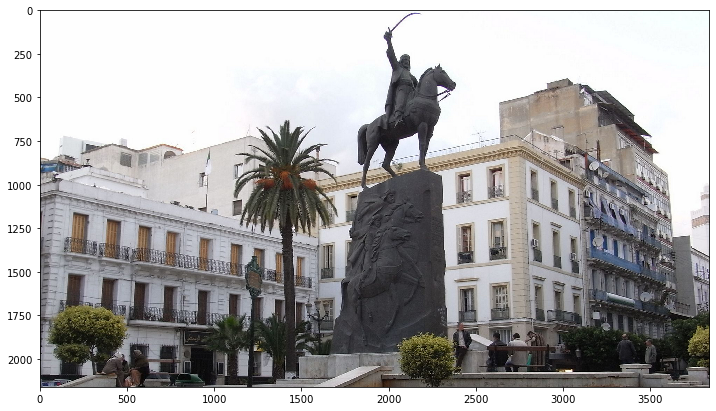

In [6]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)


print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(original_image)

In [7]:
in_buffer = allocate(shape=(height, width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(height, width), 
                           dtype=np.uint8, cacheable=1)

In [8]:
in_buffer[:] = np.array(original_image)

In [9]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    fast.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [16]:
fast.register_map.rows = height
fast.register_map.cols = width
fast.register_map.threshold = 100

In [17]:
run_kernel()
fast_image = Image.fromarray(out_buffer)

Image size: 3840x2160 pixels.


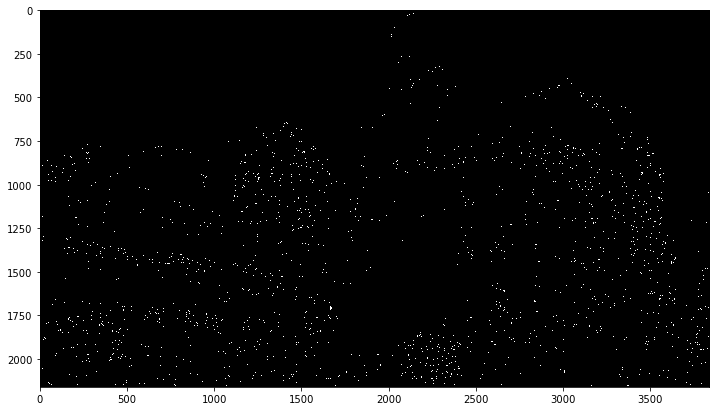

In [ ]:
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(fast_image,cmap='gray', vmin=0, vmax=255)

In [16]:
fast_image.save('corner.png')

In [17]:
%%timeit
run_kernel()
fast_image = Image.fromarray(out_buffer)

147 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
del in_buffer
del out_buffer

Image size: 3840x2160 pixels.


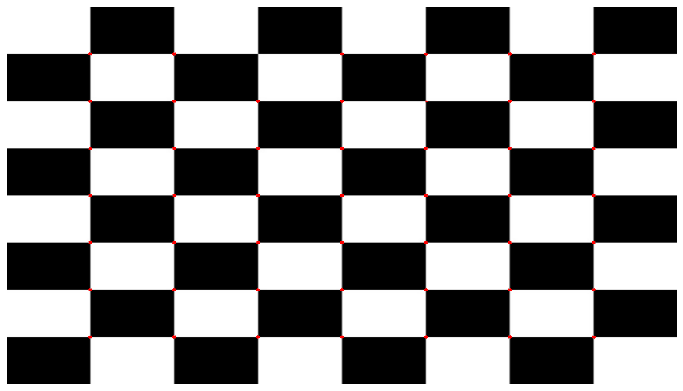

In [35]:
original_image2 = cv2.imread("/home/xilinx/jupyter_notebooks/images/corner.jpg")
grayscale=cv2.cvtColor(original_image2,cv2.COLOR_BGR2GRAY)
fast = cv2.FastFeatureDetector_create()
fast.setNonmaxSuppression(0)
# find and draw the keypoints
#kp = fast.detect(grayscale,None)
kp = fast.detect(grayscale,0)
img2 = cv2.drawKeypoints(original_image2, kp, None, color=(255,0,0))

height, width, c =img2.shape
print("Image size: {}x{} pixels.".format(width, height))

plt.figure(figsize=(12, 10));
plt.axis("off")
_ =plt.imshow(img2)

In [36]:
%%timeit
grayscale=cv2.cvtColor(original_image2,cv2.COLOR_BGR2GRAY)
fast = cv2.FastFeatureDetector_create()
fast.setNonmaxSuppression(0)
# find and draw the keypoints
kp = fast.detect(grayscale,0)
img2 = cv2.drawKeypoints(original_image2, kp, None, color=(255,0,0))

660 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
